## Plot statewise categoricwise data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [22]:
df_elec_monthly = pd.read_excel('electricity_data/sales_annual.xlsx',header=1)
df_elec_monthly.head(1)

,Year,State,Industry Sector Category,Residential,Commercial,Industrial,Transportation,Other,Total
0,2017,AK,Total Electric Industry,2060349,2704890,1420560,0.0,NaN,6185799


In [23]:
# Check whether others are only provided by the full-service providers or the energy-only providers.
print('Full-Service Providers: {}'.format(sum((df_elec_monthly['Industry Sector Category'] == 'Full-Service Providers') & (df_elec_monthly['Other'].notna()))), end=', ')
print('Energy-Only Providers: {}'.format(sum((df_elec_monthly['Industry Sector Category'] == 'Energy-Only Providers') & (df_elec_monthly['Other'].notna()))))
print('There are some states that certain kind of providers is only serving the other')

Full-Service Providers: 676, Energy-Only Providers: 105
There are some states that certain kind of providers is only serving the other


In [24]:
# Keep only the rows of 'Total Electric Industry'.
df_elec_monthly = df_elec_monthly.loc[df_elec_monthly['Industry Sector Category'] == 'Total Electric Industry',:]

In [25]:
print('Whether I need to care about the other')
print(sum(df_elec_monthly['Other'].notna()))

Whether I need to care about the other
676


In [26]:
def ratio_other(row):
    if np.isnan(row['Other']):
        return 0
    else:
        return row['Other']/row['Total']
    
df_elec_monthly['Ratio_other'] = df_elec_monthly[['Other','Total']].apply(lambda row: ratio_other(row), axis=1)

In [27]:
print('Max ratio for other: {}'.format(df_elec_monthly['Ratio_other'].max()))

Max ratio for other: 0.1097640526010866


In [28]:
states = df_elec_monthly['State'].unique()

In [29]:
def assign_size(x):
    return 'g'

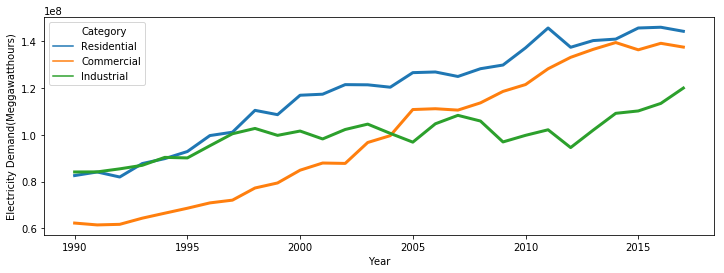

In [53]:
for ind, state in enumerate(states):
    df_state = df_elec_monthly[df_elec_monthly['State'] == 'TX']
    df_residential = df_state.loc[:,['Year', 'Residential']]
    df_residential.columns = ['Year', 'Sales']
    df_residential['Category'] = 'Residential'
    df_commercial = df_state.loc[:,['Year', 'Commercial']]
    df_commercial.columns = ['Year', 'Sales']
    df_commercial['Category'] = 'Commercial'
    df_industrial = df_state.loc[:,['Year', 'Industrial']]
    df_industrial.columns = ['Year', 'Sales']
    df_industrial['Category'] = 'Industrial'
    '''
    df_total = df_state.loc[:,['Year', 'Total']]
    df_total.columns = ['Year', 'Sales']
    df_total['Category'] = 'Total'
    '''
    df_state = df_residential.append(df_commercial).append(df_industrial)#.append(df_total)
    df_state['size'] = df_state['Category'].apply(lambda x: assign_size(x))
    plt.figure(figsize=(12, 4))
    ax = sns.lineplot(x="Year", y="Sales", hue="Category", linewidth=3, sizes=(3,3), data=df_state)
    ax.set_ylabel('Electricity Demand(Meggawatthours)')
    break

In [37]:
df_state[df_state['Category'] == 'Residential']

,Category,Electricity Sales,Sales,Year
4,Residential,NaN,90123505.0,2017
129,Residential,NaN,88311069.0,2016
254,Residential,NaN,89386373.0,2015
379,Residential,NaN,89360680.0,2014
504,Residential,NaN,89241934.0,2013
628,Residential,NaN,90109995.0,2012
752,Residential,NaN,88398416.0,2011
876,Residential,NaN,87256946.0,2010
1001,Residential,NaN,89798789.0,2009
1127,Residential,NaN,91230818.0,2008


__It's obvious that for some states，some consumers are switched from commercial to industrial or vice versa suddenly. Use TN as an example__

In [31]:
df_state = df_elec_monthly[df_elec_monthly['State'] == 'TN']
usages = df_state[['Year', 'Residential', 'Commercial', 'Industrial']].values

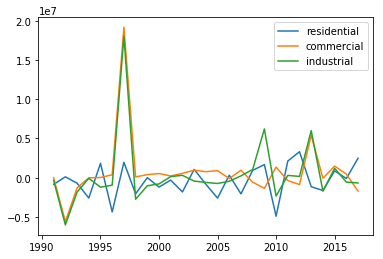

In [60]:
year = usages[:-1,0]
residential = usages[:,1]
commercial = usages[:,2]
industrial = usages[:,3]
# First order differences
diff_residential = np.diff(residential)
diff_commercial = -np.diff(commercial) # The commercial one is inversed to be compared to the industrial one.
diff_industrial = np.diff(industrial)

# plots
plt.plot(year, diff_residential)
plt.plot(year, diff_commercial)
plt.plot(year, diff_industrial)
plt.legend(["residential", "commercial", "industrial"])
plt.show()

In [61]:
# So if a sudden change is an outlier and commercial and industrial changes by a similar value but in different direction.
# Then we exchange them back.
# if either diff_industrial or diff_commercial indicates an outlier, then we take it as an outlier.
quantiles_industrial = np.percentile(diff_industrial, [25,75])
in_q = quantiles_industrial[0]
in_3q = quantiles_industrial[1]
quantiles_commercial = np.percentile(diff_commercial, [25,75])
co_q = quantiles_commercial[0]
co_3q = quantiles_commercial[1]
in_upper = in_3q+3*(in_3q-in_q)
in_lower = in_q-3*(in_3q-in_q)
co_upper = co_3q+3*(co_3q-co_q)
co_lower = co_q-3*(co_3q-co_q)

outliers = np.where(((diff_industrial > in_upper) | (diff_industrial < in_lower)) \
         & ((diff_commercial > co_upper) | (diff_commercial < co_lower)) \
        & (np.absolute((diff_industrial-diff_commercial)/np.minimum(diff_industrial, diff_commercial)) < 0.15))[0]

print('Outliers: {}'.format(outliers))

Outliers: [ 4 20 25]


In [62]:
outliers = outliers.astype('int')

for index in outliers:
    industrial[index+1:] = industrial[index+1:]-(industrial[index+1]-industrial[index])
    commercial[index+1:] = commercial[index+1:]-(commercial[index+1]-commercial[index])

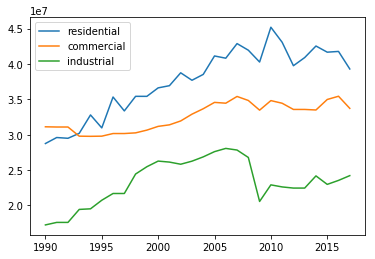

In [63]:
year = usages[:,0]
# plots
plt.plot(year, residential)
plt.plot(year, commercial)
plt.plot(year, industrial)
plt.legend(["residential", "commercial", "industrial"])
plt.show()

__Anyway, if it is the case that commercial and industrial are exchanged, the total should be stable.__